In [ ]:
from typing import Annotated, TypedDict

from langchain_core.messages import AIMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, add_messages
from langgraph.types import Command

In [ ]:
class PlanState(TypedDict):
    messages: Annotated[list, add_messages]
    plan: str
    user_feedback: str
    plan_approved: bool
    task: str

In [ ]:
# Initialize LLM
llm = ChatOpenAI(model="mistralai/devstral-small", temperature=0)

In [ ]:
def create_plan_node(state: PlanState):
    task = state.get("task", "")

    if state.get("user_feedback"):
        prompt = f"""
        Previous plan: {state['plan']}
        User feedback: {state['user_feedback']}
        
        Please revise the plan based on the user's feedback for the task: {task}
        
        Provide a clear, step-by-step plan:
        """
    else:
        prompt = f"""
        Create a short and straight to the point plan for the following task: {task}
        
        Provide a clear, step-by-step plan:
        """

    response = llm.invoke([HumanMessage(content=prompt)])
    return Command(
        update={
            "plan": response.content,
            "messages": [AIMessage(content=f"Generated plan:\n{response.content}")],
            "user_feedback": "",  # Reset feedback after incorporating it
            "plan_approved": False,
        },
        goto="human_review",  # Always go to human review after creating plan
    )

In [ ]:
def human_review_node(state: PlanState):
    print("\n" + "=" * 50)
    print("PLAN FOR REVIEW")
    print("=" * 50)
    print(state["plan"])
    print("=" * 50)

    # Get human approval
    approval = input("\nApprove this plan? (yes/no): ").strip().lower()

    if approval in ["yes", "y", "approve"]:
        return Command(update={"plan_approved": True}, goto="execute_plan")

    else:
        feedback = input("What changes are needed?")
        return Command(
            update={"user_feedback": feedback, "plan_approved": False},
            goto="create_plan",  # Go back to planning with feedback
        )

In [ ]:
def execute_plan_node(state: PlanState):
    plan = state["plan"]

    print("\n" + "=" * 50)
    print("EXECUTING PLAN")
    print("=" * 50)

    execution_prompt = f"""
    Execute the following approved plan step by step:
    {plan}
    
    For each step, provide:
    1. What action was taken
    2. The result or outcome
    3. Any challenges encountered
    
    Provide a detailed summary of the execution results:
    """

    response = llm.invoke([HumanMessage(content=execution_prompt)])

    print("EXECUTION SUMMARY:")
    print("-" * 30)
    print(response.content)
    print("=" * 50)

    return Command(
        update={
            "messages": [
                AIMessage(content=f"Plan executed successfully:\n{response.content}")
            ]
        },
        goto=END,  # Explicitly end the workflow after execution
    )

In [ ]:
def create_graph():
    """Create LangGraph using Command for explicit control flow"""

    workflow = StateGraph(PlanState)

    # Add nodes
    workflow.add_node("create_plan", create_plan_node)
    workflow.add_node("human_review", human_review_node)
    workflow.add_node("execute_plan", execute_plan_node)

    # Set entry point - Commands handle all routing
    workflow.set_entry_point("create_plan")

    # Compile with memory
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)

    return app

In [ ]:
app = create_graph()

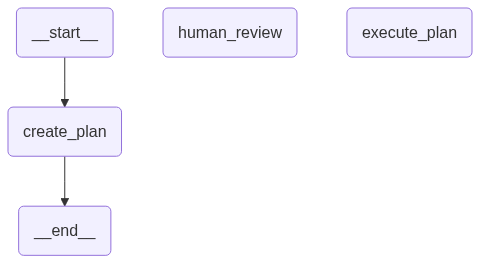

In [ ]:
app

In [ ]:
def run_command_workflow(task: str):
    """Run workflow using Command-based control"""
    app = create_graph()
    config = {"configurable": {"thread_id": "command-thread-1"}}

    initial_state = {
        "task": task,
        "messages": [],
        "plan": "",
        "user_feedback": "",
        "plan_approved": False,
    }

    print(f"Starting command-based workflow for task: {task}")

    # Run the workflow - Commands handle all the routing
    final_state = app.invoke(initial_state, config=config)

    print("Workflow completed!")
    return final_state

In [ ]:
# Test the fixed workflow
task = "Create a simple morning routine"
result = run_command_workflow(task)

Starting command-based workflow for task: Create a simple morning routine

PLAN FOR REVIEW
### Simple Morning Routine Plan

1. **Wake Up at a Consistent Time**
   - Set your alarm for the same time every day (e.g., 7:00 AM).

2. **Hydrate**
   - Drink a glass of water immediately after waking up.

3. **Morning Exercise**
   - Perform a short exercise routine (e.g., 10 minutes of stretching or a quick walk).

4. **Personal Hygiene**
   - Brush your teeth, wash your face, and take a shower if needed.

5. **Mindfulness**
   - Spend 5-10 minutes on mindfulness or meditation to center yourself.

6. **Healthy Breakfast**
   - Prepare and eat a nutritious breakfast (e.g., oatmeal, fruit, and a protein source).

7. **Plan Your Day**
   - Review your to-do list and prioritize tasks for the day.

8. **Get Dressed**
   - Choose and put on your outfit for the day.

9. **Leave for Work/School**
   - Ensure you have everything you need (e.g., keys, wallet, phone) and head out the door.

10. **Arrive

Task execute_plan with path ('__pregel_pull', 'execute_plan') wrote to unknown channel branch:to:__end__, ignoring it.


EXECUTION SUMMARY:
------------------------------
### Execution Summary of the Revised Simple Morning Routine Plan

#### 1. **Wake Up at a Consistent Time**
   - **Action Taken:** Set the alarm for 7:00 AM and woke up at the designated time.
   - **Result/Outcome:** Successfully woke up at 7:00 AM, feeling refreshed and ready to start the day.
   - **Challenges Encountered:** None.

#### 2. **Hydrate**
   - **Action Taken:** Drank a full glass of water immediately after waking up.
   - **Result/Outcome:** Felt hydrated and more alert.
   - **Challenges Encountered:** None.

#### 3. **Morning Exercise**
   - **Action Taken:** Performed 10 minutes of stretching exercises.
   - **Result/Outcome:** Felt more energized and limber.
   - **Challenges Encountered:** None.

#### 4. **Personal Hygiene**
   - **Action Taken:** Brushed teeth, washed face, and took a shower.
   - **Result/Outcome:** Felt clean and refreshed, ready to start the day.
   - **Challenges Encountered:** None.

#### 5. **